### BATINA AGASA FERVENT
#### Homework 5

In [1]:
import pandas as pd
import tqdm
import py2neo
from py2neo import Graph, Node, Relationship
import csv
import tqdm
import itertools

FR_target = pd.read_csv(r"C:\Users\ferve\Documents\NoSQL\Homeworks\FR_target.csv")

FR_target.drop_duplicates('new_id', inplace = True)

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"),name="neo4j")
graph.delete_all()

try:
    graph.run("CREATE CONSTRAINT ON (n:Streamer) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")

transaction_list = []
iteration = 0

for row in tqdm.tqdm(FR_target.iterrows()):
    id_ = row[1]["id"]
    views = row[1]["views"]
    days = row[1]["days"]
    mature = row[1]["mature"]
    new_id = row[1]["new_id"]
    partner = row[1]["partner"]
    transaction_list.append({"id_":id_,"views":views,"days":days,"mature":mature,"new_id":new_id,"partner":partner})
    iteration += 1
    transaction = "UNWIND $json as data CREATE (n:Streamer) SET n = data"
    graph.run(transaction, json=transaction_list)
    transaction_list = []
    
    
graph.run(transaction, json=transaction_list)

6549it [00:55, 118.22it/s]


(No data)

In [2]:
print(FR_target)

             id  days  mature  views  partner  new_id
0     150417538   577    True    775    False    4867
1     125723704   861    True   2585    False    3692
2     155971814   523   False   1566    False    3816
3      35832890  2234   False   9713    False     416
4      46787750  1896    True  44529    False    4502
...         ...   ...     ...    ...      ...     ...
6546   29196284  2061   False   3822    False    6546
6547  124327806   880    True  30313    False    2392
6548  144229380   640    True   5022    False     391
6549  131423064   736   False   2658    False    2793
6550   45419243  1929    True   3743    False    1092

[6549 rows x 6 columns]


In [3]:
FR_edges = pd.read_csv(r"C:\Users\ferve\Documents\NoSQL\Homeworks\FR_edges.csv")
transaction_list = []
transaction = """UNWIND $json as data
    MATCH (a:Streamer),(b:Streamer)
    WHERE a.new_id = data.from AND b.new_id = data.to
    MERGE (a)-[r:RELATION]->(b)
    ON CREATE
    SET r.n_collab = 1
    ON MATCH
    SET r.n_collab = r.n_collab + 1
    """
it = 0
for edge in tqdm.tqdm(FR_edges.groupby(["from"])):
    related_ids = edge[1]["to"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"from":sh1,"to":sh2})
        it +=1
        graph.run(transaction, json=transaction_list)
        transaction_list = []
graph.run(transaction, json=transaction_list)

  1%|          | 38/5882 [03:14<8:17:45,  5.11s/it] 


KeyboardInterrupt: 

### 1) Give the IDs of the top 10 streamers that have atleast one collaboration.

In [23]:

query = """MATCH (s:Streamer)
WHERE exists(s.id_)
RETURN s
ORDER BY s.views DESC
LIMIT 10"""
data = graph.run(query).to_data_frame()
list(data["s"])

[Node('Streamer', days=1479, id_=71852533, mature=False, new_id=3459, partner=True, views=108432615),
 Node('Streamer', days=1311, id_=84934385, mature=False, new_id=6420, partner=True, views=62713570),
 Node('Streamer', days=2613, id_=24147592, mature=False, new_id=5511, partner=True, views=44534929),
 Node('Streamer', days=2027, id_=41719107, mature=True, new_id=2161, partner=True, views=44374644),
 Node('Streamer', days=386, id_=174955366, mature=False, new_id=2799, partner=True, views=43059742),
 Node('Streamer', days=610, id_=147337432, mature=False, new_id=5968, partner=True, views=42801507),
 Node('Streamer', days=2075, id_=40063341, mature=False, new_id=1751, partner=True, views=38404078),
 Node('Streamer', days=660, id_=142506321, mature=False, new_id=5804, partner=True, views=37754841),
 Node('Streamer', days=2384, id_=29478753, mature=False, new_id=1552, partner=True, views=34295755),
 Node('Streamer', days=2460, id_=27528066, mature=False, new_id=5844, partner=True, views=2

### 2) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

C:\Users\ferve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


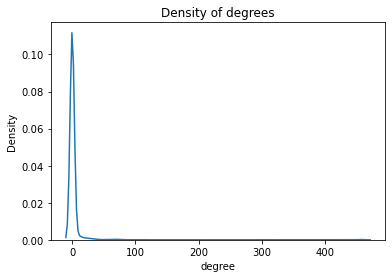

In [20]:

import seaborn as sns
query = """
MATCH (p)
WITH p, size((p)-[:RELATION]->()) as degree
RETURN degree;
"""
data = graph.run(query).to_data_frame()
ax = sns.distplot(data["degree"],hist=False)
ax.title.set_text("Density of degrees")


##### On observe une loi d'échelle de puissance au point zéro avec y=1/(d)exposannt(alpha) comme répartition de la distribution.

### 3) How many streamers has the tag "mature" ?

In [19]:

query = """
MATCH (s:Streamer)
WHERE s.mature=true
with count(s) as nombre
RETURN nombre
"""
graph.run(query)


nombre
2414


##### On compte 2414 tag "mature"

### 4) Is the collaboration correlated to the "mature" tag ?

In [18]:
query = """
MATCH (p:Streamer)-[r:RELATION]->()
where p.mature = TRUE
RETURN p.mature
"""
graph.run(query)


p.mature
true
true
true


##### Oui la collaboration est est correlée au tag "mature"

### 5) Do partners collaborate more than non partners ?

In [17]:

#On compte d'abord le nombre de partners qui collaborent
query = """
MATCH (s:Streamer)-[r:RELATION]->()
WHERE s.partner = True
with count(s) as nombre
return nombre
"""
graph.run(query)
## Il y a 5648 partners qui collaborent


nombre
5648


In [16]:
#les partners qui ne collaborent pas :
query1 = """
MATCH (s:Streamer)-[r:RELATION]->()
WHERE s.partner = false
with count(s) as nombre
return nombre
"""
graph.run(query1)

#les personnes qui ne collaborent pas sont 99247

nombre
7591


##### Non, les partners qui ne collaborent pas sont supérieurs à ceux qui collaborent. 